In [2]:
import ase
import ase.io
from ase.io import xsf
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
%matplotlib inline

In [7]:
dataframe_df2 = pd.read_pickle("DataFrame_df2.pkl")

In [8]:
dataframe_df2.columns

Index(['uuid', 'structure', 'cell', 'volume',
       'relevant_dimension_of_highest_dimensionality_substructure',
       'binding_energy_per_substructure', 'binding_energy', 'label',
       'number_of_atoms_in_bulk',
       'number_of_highest_dimensionality_substructures_in_bulk',
       'sub_structure_spg', 'sub_structure_dim', 'energy_bulk',
       'sub_structure_formula', 'PMG Structure from ASE Atoms'],
      dtype='object')

In [73]:
structures = list(dataframe_df2["PMG Structure from ASE Atoms"])
gridpoints = list(dataframe_df2.index)

In [74]:
features = {n:{} for n in gridpoints}

In [75]:
for name in gridpoints:
    features[name]["structure"]=dataframe_df2["PMG Structure from ASE Atoms"][name]

In [76]:
data=pd.DataFrame.from_dict(features).T
data.head()

,structure
0,"[[ 0. 0. 29.0441583] Cd, [ 0. ..."
1,"[[0. 0. 0.] Fe, [0. 2.06980071 4.36433..."
2,"[[2.1386 4.301805 3.209025] Er, [ 2.1386 -..."
3,"[[0. 0. 9.5697] Ba, [0. 0. 5.6..."
4,"[[0. 2.414 1.49473] Ba, [2.414 0. ..."


In [144]:
features_dict={}
## 1. initialize the dictionary for each site
for index,row in data.iterrows():
    structure=row["structure"]
    for atomidx in range(structure.num_sites):
        site_name="%s_%i"%(index,atomidx)
        features_dict[site_name]={}

In [145]:
features_dict

{'0_0': {},
 '0_1': {},
 '0_2': {},
 '0_3': {},
 '0_4': {},
 '0_5': {},
 '0_6': {},
 '0_7': {},
 '0_8': {},
 '0_9': {},
 '0_10': {},
 '0_11': {},
 '0_12': {},
 '0_13': {},
 '0_14': {},
 '1_0': {},
 '1_1': {},
 '1_2': {},
 '2_0': {},
 '2_1': {},
 '2_2': {},
 '2_3': {},
 '2_4': {},
 '2_5': {},
 '2_6': {},
 '2_7': {},
 '3_0': {},
 '3_1': {},
 '3_2': {},
 '4_0': {},
 '4_1': {},
 '4_2': {},
 '4_3': {},
 '4_4': {},
 '4_5': {},
 '5_0': {},
 '5_1': {},
 '5_2': {},
 '5_3': {},
 '5_4': {},
 '5_5': {},
 '5_6': {},
 '5_7': {},
 '5_8': {},
 '5_9': {},
 '5_10': {},
 '5_11': {},
 '5_12': {},
 '5_13': {},
 '5_14': {},
 '5_15': {},
 '5_16': {},
 '5_17': {},
 '5_18': {},
 '5_19': {},
 '5_20': {},
 '5_21': {},
 '5_22': {},
 '5_23': {},
 '5_24': {},
 '5_25': {},
 '5_26': {},
 '5_27': {},
 '6_0': {},
 '6_1': {},
 '6_2': {},
 '6_3': {},
 '6_4': {},
 '6_5': {},
 '6_6': {},
 '6_7': {},
 '6_8': {},
 '6_9': {},
 '6_10': {},
 '6_11': {},
 '6_12': {},
 '6_13': {},
 '6_14': {},
 '6_15': {},
 '6_16': {},
 '6_17': {

In [2]:
from matminer.featurizers.site import CrystalNNFingerprint, GaussianSymmFunc, SiteElementalProperty,AGNIFingerprints,LocalPropertyDifference

In [147]:
## 2. Site Elemental Property
property_list=("Number","AtomicWeight","Row","Column","Electronegativity","CovalentRadius")
SEP = SiteElementalProperty(properties=property_list)
colnames=SEP._generate_column_labels(multiindex=False,return_errors=False)
for index,row in data.iterrows():
    structure=row["structure"]
    for atomidx in range(structure.num_sites):
        feat=SEP.featurize(structure,idx=atomidx)
        site_name="%s_%i"%(index,atomidx)
        features_dict[site_name].update(dict(zip(colnames, feat)))

In [148]:
features_dict['0_0']

{'site Number': 48.0,
 'site AtomicWeight': 112.411,
 'site Row': 5.0,
 'site Column': 12.0,
 'site Electronegativity': 1.69,
 'site CovalentRadius': 144.0}

*The ***AGNI*** method was developed as a framework for machine learning force field development in which the forces are calculated directly without going through energy predictions. The associated fingerprint is given by $V_i,α,k$ below where $α$ denotes the direction (x,y or z) of the force between atoms $i$ and $j$ separated by distance $r_{ij}$. The parameter $w$ corresponds to the width of Gaussians placed at positions $a_k$ within a cutoff distance $R_c$. Similarly to the BP fingerprint, $f_c$ is the cutofff function ensuring a smooth transition to zero at $R_c$.*

$V_{i,α,k}=\sum_{j≠i}\frac{r^α_{ij}}{r_{ij}}\frac{1}{\sqrt[2]{2πw}}e^{-0.5}(\frac{r_{ij}−a_k}{w})^2f_c(r_{ij})$

*For the SEING implementation of the AGNI fingerprint, gaussian centers are uniformly chosen between 0 and the cutoff disance $R_c$. The only parameter necessary is the dimensionality of the fingerprint with determines the number of such Gaussian centers to generate. This fingerprint does not support derivative calculations.*

***REF: T. D. Huan, R. Batra, J. Chapman, S. Krishnan, L. Chen and R. Ramprasad, npj Comput. Mater., 2017, 3, 89–109.***

In [149]:
## 3. AGNI
AGNI = AGNIFingerprints(cutoff=5,directions=[None])
colnames=AGNI._generate_column_labels(multiindex=False,return_errors=False)
for index,row in data.iterrows():
    structure=row["structure"]
    for atomidx in range(structure.num_sites):
        feat=AGNI.featurize(structure,idx=atomidx)
        site_name="%s_%i"%(index,atomidx)
        features_dict[site_name].update(dict(zip(colnames, feat)))

In [7]:
AGNI.citations()

['@article{Botu2015, author = {Botu, Venkatesh and Ramprasad, Rampi},doi = {10.1002/qua.24836},journal = {International Journal of Quantum Chemistry},number = {16},pages = {1074--1083},title = {{Adaptive machine learning framework to accelerate ab initio molecular dynamics}},volume = {115},year = {2015}}']

In [150]:
features_dict['0_0']

{'site Number': 48.0,
 'site AtomicWeight': 112.411,
 'site Row': 5.0,
 'site Column': 12.0,
 'site Electronegativity': 1.69,
 'site CovalentRadius': 144.0,
 'AGNI eta=8.00e-01': 1.8850978284443492e-06,
 'AGNI eta=1.23e+00': 0.005663481900513201,
 'AGNI eta=1.88e+00': 0.17212849799487498,
 'AGNI eta=2.89e+00': 0.7605500671530321,
 'AGNI eta=4.43e+00': 1.4680915021909848,
 'AGNI eta=6.80e+00': 1.9589139944822356,
 'AGNI eta=1.04e+01': 2.218982670126298,
 'AGNI eta=1.60e+01': 2.340674067374659}

*Behler-Parinello (BP) also called “Gaussian” fingerprints are local fingerprints based on symmetry functions. Two of such symmetry functions are given by the radial and angular componenets $G^{rad}$ and $G^{ang}$ below where summations run over all neighbors $j$ and $k$ separated by distances $R_{ij}$ and $R_{ik}$ with respect to atom $i$ within a cutoff distance $R_c$ around $i$. $θ_{ijk}$ is the angle between atoms $i$,$j$ and $k$. $η$, $R_s$, $λ$ and $ζ$ are parameters whose values are chosen by the user. $f_c$ is a cutoff function used to ensure a smooth transition to zero at the Rc.*

$G^{rad}_i = \sum_je^{−η(R_{ij}−R_{s})^2}f_c(R_{ij})$


$G^{rad}_i=2^{1−ζ}\sum_{j,k≠i}(1+λcosθ_{ijk})^ζe^{−η(R^2_{ij}+R^2_{ik}+R^2_{jk})^2}f_c(R_{ij})f_c(R_{ij})f_c(R_{ij})$


$fc= \left\{ 
  \begin{array}{ c l }
    0.5[cos(\frac{πR_{ij}}{R_c})+1] & \quad \textrm{if $R_{ij} \leq R_c$ } \\
    0                 & \quad \textrm{$R_{ij}> R_c$}
  \end{array}
\right.$
 
*The SEING implementation of the BP fingerprint only requires the parameters $η$, $λ$ and $ζ$ as $R_s$ is automatically set to zero.*

***REF: J. Behler and M. Parrinello, Phys. Rev. Lett., 2007, 98, 146401.***

In [151]:
## 4. Gaussian Symmetry Functions 
GSF = GaussianSymmFunc(cutoff=5)
colnames=GSF._generate_column_labels(multiindex=False,return_errors=False)
for index,row in data.iterrows():
    structure=row["structure"]
    for atomidx in range(structure.num_sites):
        feat=GSF.featurize(structure,idx=atomidx)
        site_name="%s_%i"%(index,atomidx)
        features_dict[site_name].update(dict(zip(colnames, feat)))

In [9]:
GSF.citations()

['@Article{Behler2011, author = {Jörg Behler}, title = {Atom-centered symmetry functions for constructing high-dimensional neural network potentials}, journal = {The Journal of Chemical Physics}, year = {2011}, volume = {134}, number = {7}, pages = {074106}, doi = {10.1063/1.3553717}}',
 '@Article{Khorshidi2016, author = {Alireza Khorshidi and Andrew A. Peterson}, title = {Amp : A modular approach to machine learning in atomistic simulations}, journal = {Computer Physics Communications}, year = {2016}, volume = {207}, pages = {310--324}, doi = {10.1016/j.cpc.2016.05.010}}']

In [152]:
features_dict['0_0']

{'site Number': 48.0,
 'site AtomicWeight': 112.411,
 'site Row': 5.0,
 'site Column': 12.0,
 'site Electronegativity': 1.69,
 'site CovalentRadius': 144.0,
 'AGNI eta=8.00e-01': 1.8850978284443492e-06,
 'AGNI eta=1.23e+00': 0.005663481900513201,
 'AGNI eta=1.88e+00': 0.17212849799487498,
 'AGNI eta=2.89e+00': 0.7605500671530321,
 'AGNI eta=4.43e+00': 1.4680915021909848,
 'AGNI eta=6.80e+00': 1.9589139944822356,
 'AGNI eta=1.04e+01': 2.218982670126298,
 'AGNI eta=1.60e+01': 2.340674067374659,
 'G2_0.05': 2.386320622537986,
 'G2_4.0': 0.5235171352478238,
 'G2_20.0': 0.0016835630951716253,
 'G2_80.0': 8.675066810331334e-13,
 'G4_0.005_1.0_1.0': 0.22674016780138187,
 'G4_0.005_1.0_-1.0': 0.1097184190708285,
 'G4_0.005_4.0_1.0': 0.09863788933266876,
 'G4_0.005_4.0_-1.0': 0.010765505455389963}

In [153]:
from matminer.featurizers.structure import MinimumRelativeDistances

***It's relatively slow, so try on PC***

In [154]:
# ## 5. MinimumRelativeDistances
# MRD = MinimumRelativeDistances(flatten = False)
# colnames=MRD._generate_column_labels(multiindex=False,return_errors=False)
# print(colnames)
# for index,row in data.iterrows():
#     structure=row["structure"]
#     feat=MRD.featurize(structure)[0]
#     for atomidx in range(structure.num_sites):
#         site_name="%s_%i"%(index,atomidx)
#         #features_dict[site_name].update(dict(zip(colnames, feat[atomidx])))
#         features_dict[site_name]['minimum relative distance of each site'] = feat[atomidx]

In [155]:
from matminer.featurizers.site import CrystalNNFingerprint

In [156]:
# ## 6. Gaussian Symmetry Functions
# CNNF = CrystalNNFingerprint.from_preset("ops")
# colnames=CNNF._generate_column_labels(multiindex=False,return_errors=False)
# for index,row in data.iterrows():
#     structure=row["structure"]
#     for atomidx in range(structure.num_sites):
#         feat=CNNF.featurize(structure,idx=atomidx)
#         site_name="%s_%i"%(index,atomidx)
#         features_dict[site_name].update(dict(zip(colnames, feat)))

In [157]:
df_features=pd.DataFrame.from_dict(features_dict).T.astype(float)
df_features.head()

,site Number,site AtomicWeight,site Row,site Column,site Electronegativity,site CovalentRadius,AGNI eta=8.00e-01,AGNI eta=1.23e+00,AGNI eta=1.88e+00,AGNI eta=2.89e+00,...,AGNI eta=1.04e+01,AGNI eta=1.60e+01,G2_0.05,G2_4.0,G2_20.0,G2_80.0,G4_0.005_1.0_1.0,G4_0.005_1.0_-1.0,G4_0.005_4.0_1.0,G4_0.005_4.0_-1.0
0_0,48.0,112.411,5.0,12.0,1.69,144.0,0.000002,0.005663,0.172128,0.760550,...,2.218983,2.340674,2.386321,0.523517,0.001684,8.675067e-13,0.226740,0.109718,0.098638,0.010766
0_1,48.0,112.411,5.0,12.0,1.69,144.0,0.000002,0.005655,0.172002,0.760217,...,2.218466,2.340151,2.385795,0.523249,0.001681,8.624274e-13,0.226528,0.109579,0.098562,0.010749
0_2,48.0,112.411,5.0,12.0,1.69,144.0,0.000002,0.005663,0.172128,0.760550,...,2.218983,2.340674,2.386321,0.523517,0.001684,8.675067e-13,0.226740,0.109718,0.098638,0.010766
0_3,48.0,112.411,5.0,12.0,1.69,144.0,0.000002,0.005663,0.172128,0.760550,...,2.218983,2.340674,2.386321,0.523517,0.001684,8.675067e-13,0.226740,0.109718,0.098638,0.010766
0_4,48.0,112.411,5.0,12.0,1.69,144.0,0.000002,0.005663,0.172128,0.760550,...,2.218983,2.340674,2.386321,0.523517,0.001684,8.675067e-13,0.226740,0.109718,0.098638,0.010766


In [158]:
df_features.to_pickle("features_SiteElementalProperty_AGNIFingerprint_GaussianSymmetryFunction.pkl")

In [4]:
df_features = pd.read_pickle("features_SiteElementalProperty_AGNIFingerprint_GaussianSymmetryFunction.pkl")

***Each structure has different number of atoms, so let's put all in different column ---> As a result, there will be different number of columns for different structures ---> then we can put Zero for the ones that does not have that columns***

In [9]:
structures = list(dataframe_df2["PMG Structure from ASE Atoms"])
gridpoints = list(dataframe_df2.index)

In [10]:
features = {n:{} for n in gridpoints}
for name in gridpoints:
    features[name]["structure"]=dataframe_df2["PMG Structure from ASE Atoms"][name]

In [11]:
data=pd.DataFrame.from_dict(features).T
data.head()

,structure
0,[[-7.99325051e-18 -1.35384926e-17 2.90441583e...
1,"[[0. 0. 0.] Fe, [7.65128701e-17 2.06980071e+00..."
2,"[[2.1386 4.301805 3.209025] Er, [ 2.1386 -..."
3,[[-1.10578213e-16 1.10578213e-16 9.56970000e...
4,"[[0. 2.414 1.49473] Ba, [2.414 0. ..."


In [12]:
features_dict={n:{} for n in gridpoints}
#features_dict.keys()

In [13]:
from matminer.featurizers.site import CrystalNNFingerprint, GaussianSymmFunc, SiteElementalProperty,AGNIFingerprints,LocalPropertyDifference

In [14]:
## 2. Site Elemental Property
property_list=("Number","AtomicWeight","Row","Column","Electronegativity","CovalentRadius")
SEP = SiteElementalProperty(properties=property_list)
colnames=SEP._generate_column_labels(multiindex=False,return_errors=False)
for index,row in data.iterrows():
    structure=row["structure"]
    for atomidx in range(structure.num_sites):
        feat=SEP.featurize(structure,idx=atomidx)
        colname=["%s_%i"%(i,atomidx) for i in colnames]
        features_dict[index].update(dict(zip(colname, feat)))

In [15]:
features_dict[0]

{'site Number_0': 48.0,
 'site AtomicWeight_0': 112.411,
 'site Row_0': 5.0,
 'site Column_0': 12.0,
 'site Electronegativity_0': 1.69,
 'site CovalentRadius_0': 144.0,
 'site Number_1': 48.0,
 'site AtomicWeight_1': 112.411,
 'site Row_1': 5.0,
 'site Column_1': 12.0,
 'site Electronegativity_1': 1.69,
 'site CovalentRadius_1': 144.0,
 'site Number_2': 48.0,
 'site AtomicWeight_2': 112.411,
 'site Row_2': 5.0,
 'site Column_2': 12.0,
 'site Electronegativity_2': 1.69,
 'site CovalentRadius_2': 144.0,
 'site Number_3': 48.0,
 'site AtomicWeight_3': 112.411,
 'site Row_3': 5.0,
 'site Column_3': 12.0,
 'site Electronegativity_3': 1.69,
 'site CovalentRadius_3': 144.0,
 'site Number_4': 48.0,
 'site AtomicWeight_4': 112.411,
 'site Row_4': 5.0,
 'site Column_4': 12.0,
 'site Electronegativity_4': 1.69,
 'site CovalentRadius_4': 144.0,
 'site Number_5': 53.0,
 'site AtomicWeight_5': 126.90447,
 'site Row_5': 5.0,
 'site Column_5': 17.0,
 'site Electronegativity_5': 2.66,
 'site CovalentRa

In [16]:
## 3. AGNI
property_list=("Number","AtomicWeight","Row","Column","Electronegativity","CovalentRadius")
AGNI = AGNIFingerprints(cutoff=5,directions=[None])
colnames=AGNI._generate_column_labels(multiindex=False,return_errors=False)
for index,row in data.iterrows():
    structure=row["structure"]
    for atomidx in range(structure.num_sites):
        feat=AGNI.featurize(structure,idx=atomidx)
        colname=["%s_%i"%(i,atomidx) for i in colnames]
        features_dict[index].update(dict(zip(colname, feat)))

In [17]:
#features_dict[0]

In [18]:
## 4. Gaussian Symmetry Functions 
GSF = GaussianSymmFunc(cutoff=5)
colnames=GSF._generate_column_labels(multiindex=False,return_errors=False)
for index,row in data.iterrows():
    structure=row["structure"]
    for atomidx in range(structure.num_sites):
        feat=GSF.featurize(structure,idx=atomidx)
        colname=["%s_%i"%(i,atomidx) for i in colnames]
        features_dict[index].update(dict(zip(colname, feat)))

In [19]:
#features_dict[0]

In [20]:
df_features=pd.DataFrame.from_dict(features_dict).T#.astype(float)

In [21]:
df_features.columns

Index(['site Number_0', 'site AtomicWeight_0', 'site Row_0', 'site Column_0',
       'site Electronegativity_0', 'site CovalentRadius_0', 'site Number_1',
       'site AtomicWeight_1', 'site Row_1', 'site Column_1',
       ...
       'G4_0.005_4.0_1.0_214', 'G4_0.005_4.0_-1.0_214', 'G2_0.05_215',
       'G2_4.0_215', 'G2_20.0_215', 'G2_80.0_215', 'G4_0.005_1.0_1.0_215',
       'G4_0.005_1.0_-1.0_215', 'G4_0.005_4.0_1.0_215',
       'G4_0.005_4.0_-1.0_215'],
      dtype='object', length=4752)

In [22]:
[df_features.isna().sum() == 2391]

[site Number_0               False
 site AtomicWeight_0         False
 site Row_0                  False
 site Column_0               False
 site Electronegativity_0    False
                             ...  
 G2_80.0_215                  True
 G4_0.005_1.0_1.0_215         True
 G4_0.005_1.0_-1.0_215        True
 G4_0.005_4.0_1.0_215         True
 G4_0.005_4.0_-1.0_215        True
 Length: 4752, dtype: bool]

In [23]:
df_features = df_features.fillna(0)

In [24]:
df_features.isna().sum()

site Number_0               0
site AtomicWeight_0         0
site Row_0                  0
site Column_0               0
site Electronegativity_0    0
                           ..
G2_80.0_215                 0
G4_0.005_1.0_1.0_215        0
G4_0.005_1.0_-1.0_215       0
G4_0.005_4.0_1.0_215        0
G4_0.005_4.0_-1.0_215       0
Length: 4752, dtype: int64

In [25]:
df = pd.concat([dataframe_df2['label'], df_features], axis = 1)

In [26]:
df.head()

,label,site Number_0,site AtomicWeight_0,site Row_0,site Column_0,site Electronegativity_0,site CovalentRadius_0,site Number_1,site AtomicWeight_1,site Row_1,...,G4_0.005_4.0_1.0_214,G4_0.005_4.0_-1.0_214,G2_0.05_215,G2_4.0_215,G2_20.0_215,G2_80.0_215,G4_0.005_1.0_1.0_215,G4_0.005_1.0_-1.0_215,G4_0.005_4.0_1.0_215,G4_0.005_4.0_-1.0_215
0,EE,48.0,112.411,5.0,12.0,1.69,144.0,48.0,112.411,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,EE,26.0,55.845,4.0,8.0,1.83,132.0,17.0,35.453,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,EE,68.0,167.259,6.0,3.0,1.24,189.0,68.0,167.259,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,PE,56.0,137.327,6.0,2.0,0.89,215.0,56.0,137.327,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,EE,56.0,137.327,6.0,2.0,0.89,215.0,56.0,137.327,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


***Train Test Split***

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
X = df.drop('label', axis = 1).values
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

***Decision Tree Classifier***

In [29]:
from sklearn.tree import DecisionTreeClassifier

In [30]:
dtree = DecisionTreeClassifier()

In [31]:
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

In [32]:
predictions = dtree.predict(X_test)

***Evaluation***

In [33]:
from sklearn.metrics import classification_report, confusion_matrix

In [34]:
print(classification_report(y_test,predictions))
print('\n')
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

          EE       0.74      0.76      0.75       341
         HBE       0.52      0.54      0.53       167
          PE       0.53      0.50      0.51       210

    accuracy                           0.63       718
   macro avg       0.60      0.60      0.60       718
weighted avg       0.63      0.63      0.63       718



[[258  36  47]
 [ 31  90  46]
 [ 59  47 104]]


***Random Forest Classifier***

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
RF = RandomForestClassifier()

In [37]:
RF.fit(X_train,y_train)

RandomForestClassifier()

In [38]:
predictions = RF.predict(X_test)

In [39]:
print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

          EE       0.79      0.85      0.82       341
         HBE       0.75      0.57      0.65       167
          PE       0.58      0.62      0.60       210

    accuracy                           0.72       718
   macro avg       0.71      0.68      0.69       718
weighted avg       0.72      0.72      0.71       718



[[289   7  45]
 [ 22  95  50]
 [ 56  24 130]]


***Binary***

In [46]:
df_binary = df.dropna()
df_binary.head()

,label,site Number_0,site AtomicWeight_0,site Row_0,site Column_0,site Electronegativity_0,site CovalentRadius_0,site Number_1,site AtomicWeight_1,site Row_1,...,G4_0.005_4.0_1.0_214,G4_0.005_4.0_-1.0_214,G2_0.05_215,G2_4.0_215,G2_20.0_215,G2_80.0_215,G4_0.005_1.0_1.0_215,G4_0.005_1.0_-1.0_215,G4_0.005_4.0_1.0_215,G4_0.005_4.0_-1.0_215
0,EE,48.0,112.411,5.0,12.0,1.69,144.0,48.0,112.411,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,EE,26.0,55.845,4.0,8.0,1.83,132.0,17.0,35.453,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,EE,68.0,167.259,6.0,3.0,1.24,189.0,68.0,167.259,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,PE,56.0,137.327,6.0,2.0,0.89,215.0,56.0,137.327,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,EE,56.0,137.327,6.0,2.0,0.89,215.0,56.0,137.327,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
df_binary['label'].replace(to_replace='PE', value='EE', inplace=True)
df_binary['label'].replace(to_replace='EE', value=1, inplace=True)
df_binary['label'].replace(to_replace='HBE', value=0, inplace=True)

In [48]:
df_binary['label'].value_counts()

1    1813
0     579
Name: label, dtype: int64

In [49]:
X = df_binary.drop('label', axis = 1).values
y = df_binary['label'].values

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [52]:
X_train.shape

(1674, 4752)

In [53]:
RF.fit(X_train,y_train)

RandomForestClassifier()

In [54]:
pred_RF = RF.predict(X_test)

In [55]:
print(classification_report(y_test, pred_RF))
print("\n")
print(confusion_matrix(y_test, pred_RF))

              precision    recall  f1-score   support

           0       0.84      0.42      0.56       167
           1       0.85      0.98      0.91       551

    accuracy                           0.85       718
   macro avg       0.85      0.70      0.73       718
weighted avg       0.85      0.85      0.83       718



[[ 70  97]
 [ 13 538]]


***Neural Nets***

In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [49]:
df_binary = df.replace(to_replace='PE', value = 'EE')
final_df_binary = pd.get_dummies(df_binary,columns=['label'],drop_first=True)

In [51]:
X = final_df_binary.drop('label_HBE', axis = 1).values
y = final_df_binary['label_HBE'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [53]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [54]:
X_train.shape

(1674, 4752)

In [55]:
model = Sequential()

In [56]:
model.add(Dense(units=2000,activation='relu'))
model.add(Dense(units=1000,activation='relu'))
model.add(Dense(units=1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')

In [57]:

model.fit(x=X_train, 
          y=y_train, 
          epochs=100,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )

Epoch 1/100
53/53 [==============================] - 3s 43ms/step - loss: 4.2613 - val_loss: 0.6421
Epoch 2/100
53/53 [==============================] - 2s 39ms/step - loss: 0.5550 - val_loss: 0.5593
Epoch 3/100
53/53 [==============================] - 2s 40ms/step - loss: 0.4999 - val_loss: 0.7832
Epoch 4/100
53/53 [==============================] - 2s 41ms/step - loss: 0.4801 - val_loss: 0.6829
Epoch 5/100
53/53 [==============================] - 2s 41ms/step - loss: 0.4301 - val_loss: 0.7054
Epoch 6/100
53/53 [==============================] - 3s 53ms/step - loss: 0.4157 - val_loss: 0.6232
Epoch 7/100
53/53 [==============================] - 2s 43ms/step - loss: 0.4243 - val_loss: 0.6038
Epoch 8/100
53/53 [==============================] - 2s 41ms/step - loss: 0.3799 - val_loss: 0.6324
Epoch 9/100
53/53 [==============================] - 2s 41ms/step - loss: 0.3739 - val_loss: 0.6912
Epoch 10/100
53/53 [==============================] - 2s 44ms/step - loss: 0.3814 - val_loss: 0.6303

<AxesSubplot:>

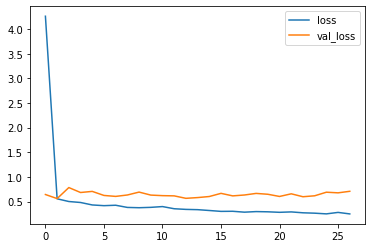

In [58]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [61]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

In [62]:
print(classification_report(y_test,y_pred))
print('\n')
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.79      0.83       551
           1       0.47      0.59      0.52       167

    accuracy                           0.75       718
   macro avg       0.67      0.69      0.68       718
weighted avg       0.77      0.75      0.76       718



[[438 113]
 [ 68  99]]
